Import module and library used

In [1]:
from typing import Dict, Text
 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

from sklearn.metrics.pairwise import cosine_similarity
import uuid

2023-06-15 22:47:22.421227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 22:47:22.545783: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-15 22:47:22.551606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-15 22:47:22.551622: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Select the column used and save it to a variable businesses

In [2]:
businesses_df = _deepnote_execute_sql('SELECT name FROM businesses', 'SQL_5C5D2FB1_2915_47AF_A658_34E9F21C61A9', audit_sql_comment='', sql_cache_mode='cache_disabled')
businesses_df

,name
0,Natural bordir terminal kelet
1,Wr Bakso Mbak nurul
2,TB Lumintu
3,OCTAVIA ID
4,Bpk ngalawi (bkl. Kambing)
...,...
544,Nares Cell
545,Sol Sepatu
546,Ms Glow
547,Basreng Mega Jaya


Select the column used and save it to a variable upvote

In [3]:
upvotes_df = _deepnote_execute_sql('SELECT users.serial AS user_id, businesses.name as business_name FROM upvotes\nINNER JOIN businesses ON businesses.id = upvotes.business_id\nINNER JOIN users ON users.id = upvotes.user_id', 'SQL_5C5D2FB1_2915_47AF_A658_34E9F21C61A9', audit_sql_comment='', sql_cache_mode='cache_disabled')
upvotes_df

,user_id,business_name
0,19,Angkringan brow gusto
1,19,BabyShop Putra Mas
2,19,Bolivar Adventure Equipment
3,19,STAR SHOES BATANG
4,19,potato Tornado & Lesehan Pindang tetel Congor ...
...,...,...
1093,69,Brahouse Galleria Jogja
1094,69,Kiloan
1095,69,Oke Mebel Jepara
1096,69,Toko Pompa Air dan Perlengkapan Bangunan Nusan...


Convert the pandas dataframe to Tensorflow Datasets

In [4]:
businesses = tf.data.Dataset.from_tensor_slices(dict(businesses_df))
upvotes = tf.data.Dataset.from_tensor_slices(dict(upvotes_df))

2023-06-15 22:47:37.436036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-15 22:47:37.436062: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-15 22:47:37.436080: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-fa0ff5c2-b244-406d-b1f4-a2f4cd653e27): /proc/driver/nvidia/version does not exist
2023-06-15 22:47:37.436352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Take an example of business data.

In [5]:
for business in businesses.take(5):
  print(business)

{'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Natural bordir terminal kelet'>}
{'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Wr Bakso Mbak nurul'>}
{'name': <tf.Tensor: shape=(), dtype=string, numpy=b'TB Lumintu'>}
{'name': <tf.Tensor: shape=(), dtype=string, numpy=b'OCTAVIA ID'>}
{'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Bpk ngalawi (bkl. Kambing)'>}


Take an example of upvotes data.

In [6]:
for upvote in upvotes.take(5):
  print(upvote)

{'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19>, 'business_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Angkringan brow gusto'>}
{'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19>, 'business_name': <tf.Tensor: shape=(), dtype=string, numpy=b'BabyShop Putra Mas'>}
{'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19>, 'business_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Bolivar Adventure Equipment'>}
{'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19>, 'business_name': <tf.Tensor: shape=(), dtype=string, numpy=b'STAR SHOES BATANG'>}
{'user_id': <tf.Tensor: shape=(), dtype=int64, numpy=19>, 'business_name': <tf.Tensor: shape=(), dtype=string, numpy=b"potato Tornado & Lesehan Pindang tetel Congor Ala Mak'e">}


Determine basic features for the model.

In [7]:
upvotes = upvotes.map(lambda x: {
    "business_name": x["business_name"],
    "user_id": x["user_id"]
})
businesses = businesses.map(lambda x: x["name"])

Assign indices for unique businesses and upvotes.

In [8]:
user_ids_vocabulary = tf.keras.layers.IntegerLookup(mask_token=None)
user_ids_vocabulary.adapt(upvotes.map(lambda x: x["user_id"]))

business_names_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
business_names_vocabulary.adapt(businesses)

Create a model using tfrs.model by implementing compute loss method

In [9]:
class BusinessesModel(tfrs.Model):
  def __init__(
      self,
      user_model: tf.keras.Model,
      business_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()
 
    self.user_model = user_model
    self.business_model = business_model
 
    self.task = task
 
  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    business_embeddings = self.business_model(features["business_name"])
 
    return self.task(user_embeddings, business_embeddings)

Define sequential models for generating the embeddings

In [10]:
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    # tf.keras.layers.Embedding(business_names_vocabulary.vocabulary_size(), 128),
    tf.keras.layers.Embedding(user_ids_vocabulary.vocabulary_size(), 128)
])

business_model = tf.keras.Sequential([
    business_names_vocabulary,
    # tf.keras.layers.Embedding(business_names_vocabulary.vocabulary_size(), 128),
    tf.keras.layers.Embedding(business_names_vocabulary.vocabulary_size(), 128)
])

task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    businesses.batch(128).map(business_model)
  )
)

Fit the model

In [11]:
model = BusinessesModel(user_model, business_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))
 
model.fit(upvotes.batch(4096), epochs=1000)

1/1 [==============================] - 0s 72ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0874 - factorized_top_k/top_5_categorical_accuracy: 0.2559 - factorized_top_k/top_10_categorical_accuracy: 0.4435 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 4489.3213 - regularization_loss: 0.0000e+00 - total_loss: 4489.3213
Epoch 502/1000
1/1 [==============================] - 0s 87ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0455 - factorized_top_k/top_5_categorical_accuracy: 0.2386 - factorized_top_k/top_10_categorical_accuracy: 0.4253 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 4489.3560 - regularization_loss: 0.0000e+00 - total_loss: 4489.3560
Epoch 503/1000
1/1 [==============================] - 0s 55ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0883 - factorized_top_k/top_5_categorical_accuracy: 0.2568 - fact

Make predictions

In [14]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    businesses.batch(100).map(lambda title: (title, model.business_model(title))))
 
_, titles = index(np.array([42]))
print(f"Top 10 recommendations for user 42: {titles[0, :10]}")

Top 10 recommendations for user 42: [b'Redbelt 92' b'Sikatkasut' b'Roti Bun Jepara dan Calzone Pizza Jepara'
 b'Es Teler 77' b'Anisah Florist' b'Legend Coffee' b'Cita Bookstore'
 b'Toko Damai' b'Yudi Anggungan Jogja' b'Gynaris']


In [15]:
query_user_id = np.array([42])

items, _ = index(np.array([42]))
item_indices = np.arange(items.shape[1])
recommendation_scores = items[0].numpy()

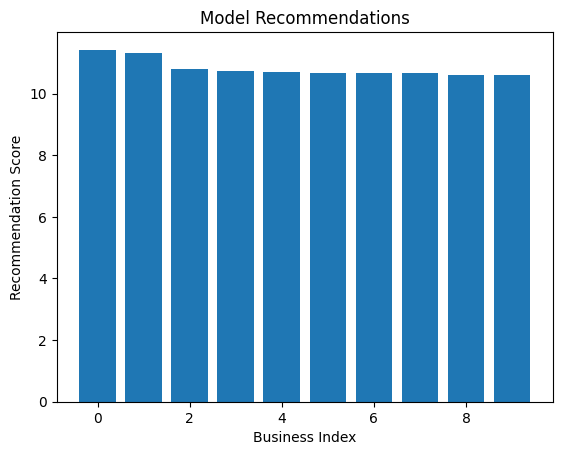

In [16]:
import matplotlib.pyplot as plt
plt.bar(item_indices, recommendation_scores)
plt.xlabel('Business Index')
plt.ylabel('Recommendation Score')
plt.title('Model Recommendations')
plt.show()

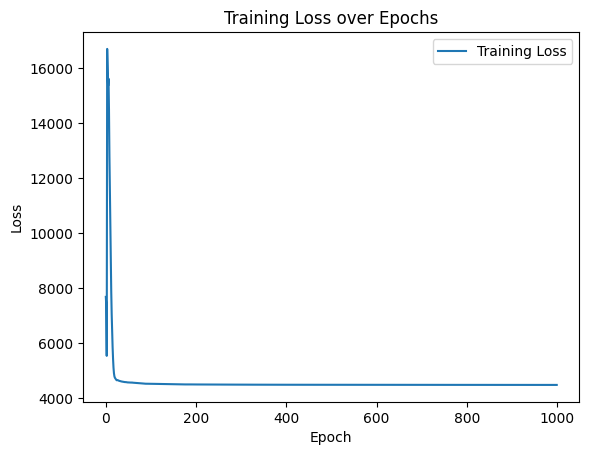

In [17]:
plt.plot(model.history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### Embeddings

Assign each embedding user to a vocabulary value.

In [18]:
users_embdeddings = user_model.weights[1].numpy()
users_idx_name = user_ids_vocabulary.get_vocabulary()

users_embdeddings.shape

(53, 128)

Assign each embedding business to a vocabulary value.

In [19]:
businesses_embdeddings = business_model.weights[1].numpy()
business_idx_name = business_names_vocabulary.get_vocabulary()

businesses_embdeddings.shape

(543, 128)

Predict to get specific embedding.

In [20]:
business_model.predict(["Roti Bun Jepara dan Calzone Pizza Jepara"])

1/1 [==============================] - 0s 87ms/step


array([[ 0.7942498 , -0.4668495 ,  0.04039759,  0.2862208 ,  0.05061981,
        -0.74348414,  0.20428935, -0.49511358, -0.320716  , -0.4492703 ,
         0.01609206, -0.41399026,  0.9149289 ,  0.51365435,  0.6765698 ,
        -0.5817221 ,  0.23833591,  1.3142514 ,  0.122578  , -0.47645888,
        -0.03848869,  0.31867802,  0.00451703,  0.3120498 , -1.2413033 ,
         0.1592106 ,  0.23105909,  0.54636097,  0.4460837 ,  0.06416543,
         0.99758255, -0.1584337 , -1.0448929 ,  0.08671515, -0.39379916,
        -0.9168633 ,  0.6518041 , -0.15934801, -0.44194606, -0.5462308 ,
        -0.41059867, -0.04393067, -0.7261115 ,  0.21568711, -0.30582693,
        -1.0468128 ,  0.10666456,  0.02038737, -0.42144156,  0.2589271 ,
        -0.6365957 ,  0.67706054,  0.292342  ,  0.49663368,  0.23797259,
         0.3675163 , -1.0737199 ,  0.41255227, -0.58316046, -0.01482944,
         0.6595105 , -1.6062804 ,  0.2591057 ,  0.15705693,  0.7657875 ,
        -0.5826637 , -0.1375021 ,  0.8914392 , -0.9

### Find Similar

Assign each embedding business. 

In [21]:
from sklearn.metrics import pairwise_distances

businesses_similarity = 1-pairwise_distances(businesses_embdeddings, metric='cosine')
businesses_similarity = np.triu(businesses_similarity)

Get the most similar business with a cosine similarity threshold greater than 0.8.

In [22]:
Business_A = np.take(business_idx_name, np.where((businesses_similarity>0.8))[0])
Business_B = np.take(business_idx_name, np.where((businesses_similarity>0.8))[1])
 
similar_businesses = pd.DataFrame({'Business_A':Business_A, 'Business_B':Business_B})
similar_businesses.head(100)

,Business_A,Business_B
0,[UNK],[UNK]
1,Alfamart,Alfamart
2,MR.DIY,MR.DIY
3,Jajanan Bakaran Njero Kampung,Jajanan Bakaran Njero Kampung
4,Indomaret,Indomaret
...,...,...
95,Toko Sepatu,Toko Sepatu
96,Toko Sandal,Toko Sandal
97,Toko Roti Kue Panjang,Toko Roti Kue Panjang
98,Toko Raja,Toko Raja


### Get User’s Recommendations with Matrix Multiplication

Multiply the two tables to get a score for each user for every business.

In [23]:
product_matrix = np.matmul(users_embdeddings, np.transpose(businesses_embdeddings))

product_matrix.shape

(53, 543)

Get the top 10 recommended businesses for the user.

In [24]:
user_42_businesses = product_matrix[users_idx_name.index(42),:]
 
np.take(business_idx_name, user_42_businesses.argsort()[::-1])[0:10]

array(['Redbelt 92', 'Sikatkasut',
       'Roti Bun Jepara dan Calzone Pizza Jepara', 'Es Teler 77',
       'Anisah Florist', 'Legend Coffee', 'Cita Bookstore', 'Toko Damai',
       'Yudi Anggungan Jogja', 'Gynaris'], dtype='<U74')

Exclude the already visited business.

In [25]:
seen_businesses = upvotes_df.query('user_id==42')['business_name'].values
 
np.setdiff1d(np.take(business_idx_name, user_42_businesses.argsort()[::-1]), seen_businesses, assume_unique=True)[0:10]

array(['Toko NUTUSCO', 'Toko Buku Bintang Mandiri',
       'Laundry Kiloan Rapi Joss', 'Angkringan Memet',
       'Jajanan Bakaran Njero Kampung', 'Kampoeng Duren Nyos',
       'Toko bunga aisyah florist', 'Xtra Laundry Jepara', 'KFC',
       'Aneka Kue Pukis, Donat Kentang, Bolang-baling, Samir'],
      dtype='<U74')

### Save and Load Model

In [26]:
import tempfile
import os
with tempfile.TemporaryDirectory() as tmp:
  path = os.path.join(tmp, "model")
 
  tf.saved_model.save(index, path)
 
  loaded = tf.saved_model.load(path)
 
  scores, titles = loaded([42])
 
  print(f"Recommendations: {titles[0][:10]}")

INFO:tensorflow:Assets written to: /tmp/tmpf1xzqurs/model/assets
INFO:tensorflow:Assets written to: /tmp/tmpf1xzqurs/model/assets
Recommendations: [b'Redbelt 92' b'Sikatkasut' b'Roti Bun Jepara dan Calzone Pizza Jepara'
 b'Es Teler 77' b'Anisah Florist' b'Legend Coffee' b'Cita Bookstore'
 b'Toko Damai' b'Yudi Anggungan Jogja' b'Gynaris']


In [27]:
path = 'saved_model'
tf.saved_model.save(index, path)

INFO:tensorflow:Assets written to: saved_model/assets
INFO:tensorflow:Assets written to: saved_model/assets


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa0ff5c2-b244-406d-b1f4-a2f4cd653e27' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>